# BPNet Hits Summarize

Call significant hits from BPNet counts deltas and then get peak set x motif map.

In [112]:
library(ggplot2)
library(GenomicRanges)
library(rtracklayer)
library(reshape2)
library(scales)
library(matrixStats)

## Load Data

### PWM Hits

In [1330]:
# all putative motif matches (from HOMER/FIMO scan)
pwm_hits = import("./pwm_hits/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40/homer.all.sorted.bed")
length(pwm_hits)
head(pwm_hits)

[1] 8377252

GRanges object with 6 ranges and 2 metadata columns:
      seqnames              ranges strand |            name     score
         <Rle>           <IRanges>  <Rle> |     <character> <numeric>
  [1]    chr10 100000298-100000307      - |      Atf4(bZIP)  8.032424
  [2]    chr10 100000313-100000322      - | Nanog(Homeobox)  4.545512
  [3]    chr10 100000356-100000365      - |       Sox4(HMG)  7.254576
  [4]    chr10 100000358-100000365      - |       Sox3(HMG)   6.83442
  [5]    chr10 100000426-100000435      + |     Olig2(bHLH)    6.4031
  [6]    chr10 100000432-100000446      + |       Rfx6(HTH)  6.827114
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [1331]:
# reads homer Motif.Names (first column) and breaks them into 
# TF name and family name (if available)
# if family name not available, uses name of TF itself
get_tf_fam <- function(homer_motif_names) {
    tfs = c()
    fams = c()
    for (x in as.character(homer_motif_names)) {
        tf_fam = strsplit(x, "/")[[1]][1]
        tf_fam = strsplit(tf_fam, "\\(")[[1]]

        if (length(tf_fam)==2) {
            tf = tf_fam[1]
            fam = sub(")", "", tf_fam[2])
        }

        else {
            tf = tf_fam[1]
            fam = tf
        }
        
        tfs = c(tfs, tf)
        fams = c(fams, fam)
    }
    
    list(tfs, fams)
}

### Peak Sets

In [4]:
BASE_PATH = "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40/"
list.files(BASE_PATH)

[1] "all_peaks.bed" "idx1.bed"      "idx10.bed"     "idx11.bed"    
 [5] "idx12.bed"     "idx13.bed"     "idx14.bed"     "idx15.bed"    
 [9] "idx16.bed"     "idx17.bed"     "idx18.bed"     "idx19.bed"    
[13] "idx2.bed"      "idx20.bed"     "idx21.bed"     "idx22.bed"    
[17] "idx23.bed"     "idx24.bed"     "idx25.bed"     "idx26.bed"    
[21] "idx27.bed"     "idx28.bed"     "idx29.bed"     "idx3.bed"     
[25] "idx30.bed"     "idx31.bed"     "idx32.bed"     "idx33.bed"    
[29] "idx34.bed"     "idx35.bed"     "idx36.bed"     "idx37.bed"    
[33] "idx38.bed"     "idx39.bed"     "idx4.bed"      "idx40.bed"    
[37] "idx5.bed"      "idx6.bed"      "idx7.bed"      "idx8.bed"     
[41] "idx9.bed"      "README.md"     "width_200bp"

In [5]:
PEAK_SET_BEDS = list.files(BASE_PATH, 
                           full.names=T,
                          pattern="*idx[0-9]*")
PEAK_SET_NAMES = sub(".bed", "", list.files(BASE_PATH, 
                          pattern="*idx[0-9]*"))
length(PEAK_SET_BEDS)
length(PEAK_SET_NAMES)

[1] 40

[1] 40

In [6]:
# alphanumeric sort 
PEAK_SET_BEDS = PEAK_SET_BEDS[order(nchar(PEAK_SET_BEDS), PEAK_SET_BEDS)]
PEAK_SET_NAMES = PEAK_SET_NAMES[order(nchar(PEAK_SET_NAMES), PEAK_SET_NAMES)]

In [7]:
PEAK_SET_BEDS
PEAK_SET_NAMES

[1] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx1.bed" 
 [2] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx2.bed" 
 [3] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx3.bed" 
 [4] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx4.bed" 
 [5] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx5.bed" 
 [6] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx6.bed" 
 [7] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx7.bed" 
 [8] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx8.bed" 
 [9] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx9.bed" 
[10] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx10.bed"
[11] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx11.bed"
[12] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx12.bed"
[13] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx13.bed"
[14] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx14.bed"
[15] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx15.bed"
[16] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx16.bed"
[17] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx17.bed"
[18] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx18.bed"
[19] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx19.bed"
[20] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx20.bed"
[21] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx21.bed"
[22] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx22.bed"
[23] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx23.bed"
[24] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx24.bed"
[25] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx25.bed"
[26] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx26.bed"
[27] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx27.bed"
[28] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx28.bed"
[29] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx29.bed"
[30] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx30.bed"
[31] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx31.bed"
[32] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx32.bed"
[33] "../../analysis/20200307_fin

[1] "idx1"  "idx2"  "idx3"  "idx4"  "idx5"  "idx6"  "idx7"  "idx8"  "idx9" 
[10] "idx10" "idx11" "idx12" "idx13" "idx14" "idx15" "idx16" "idx17" "idx18"
[19] "idx19" "idx20" "idx21" "idx22" "idx23" "idx24" "idx25" "idx26" "idx27"
[28] "idx28" "idx29" "idx30" "idx31" "idx32" "idx33" "idx34" "idx35" "idx36"
[37] "idx37" "idx38" "idx39" "idx40"

## Call BPNet Hits

Call significant motif hits from BPNet deltas for PWM hits (HOMER/FIMO) and null sequences (PWM hits shifted +/- 50bp).

In [8]:
NUM_CELL_STATES = 18

In [1263]:
BPNET_ISM_DIR = "./bpnet_scores/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40/block_ism/20200727_all_peaks_filt256_in2346_out2000/"

get_sig_peaks <- function(i, thresh=0.01) {
    motif_preds_file = sprintf("%s/cluster_idx%d.pred.tsv", BPNET_ISM_DIR, i)
    null_preds_file = sprintf("%s/cluster_idx%d.pred.null.tsv", BPNET_ISM_DIR, i)
    motif_preds = read.table(motif_preds_file, header=T)
    null_preds = read.table(null_preds_file, header=T)
    
    # right now simple cutoff based on ref-mut pred of null
    cutoff = quantile(null_preds$ref_task_0 - null_preds$mut_task_0, 1-thresh)
    
    motif_preds[motif_preds$ref_task_0 - motif_preds$mut_task_0 > cutoff, c("chr", "start", "end")]
}

In [1267]:
sig_hits = mclapply(seq(NUM_CELL_STATES), get_sig_peaks, mc.cores = 20)

In [1268]:
# consolidate across cell states
consolidated_sig_hits = unique(do.call(rbind, sig_hits))
consolidated_sig_hits = makeGRangesFromDataFrame(consolidated_sig_hits)

In [1269]:
consolidated_sig_hits

GRanges object with 1374266 ranges and 0 metadata columns:
           seqnames              ranges strand
              <Rle>           <IRanges>  <Rle>
        12    chr10 100006447-100006459      *
        13    chr10 100006448-100006460      *
        89    chr10 100038045-100038057      *
        90    chr10 100038048-100038058      *
        91    chr10 100038052-100038064      *
       ...      ...                 ...    ...
   2213909     chrX   98448709-98448719      *
   2213910     chrX   98448724-98448739      *
  22139884     chrX   98606157-98606165      *
   2214033     chrX   98956200-98956212      *
  22142052     chrY     4963614-4963628      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [1332]:
# overlap with motif calls (sig hits are peaks that subsume all motif calls)
sig_pwm_hits = pwm_hits[unique(queryHits(findOverlaps(pwm_hits, consolidated_sig_hits, type='within')))]
length(sig_pwm_hits)

[1] 2924463

In [1333]:
head(sig_pwm_hits)

GRanges object with 6 ranges and 2 metadata columns:
      seqnames              ranges strand |                      name     score
         <Rle>           <IRanges>  <Rle> |               <character> <numeric>
  [1]    chr10 100000432-100000446      + |                 Rfx6(HTH)  6.827114
  [2]    chr10 100006087-100006101      - |                 Rfx6(HTH)  4.739767
  [3]    chr10 100006088-100006097      - |           Nanog(Homeobox)  6.885977
  [4]    chr10 100006089-100006106      + | Pitx1:Ebox(Homeobox,bHLH)  9.297372
  [5]    chr10 100006090-100006101      - |                Atf3(bZIP)  6.918307
  [6]    chr10 100006091-100006102      - |                 Fos(bZIP)  7.839181
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [940]:
# write to file
df = data.frame(seq=seqnames(sig_pwm_hits),
               starts = format(start(sig_pwm_hits)-1, scientific = F),
               ends=format(end(sig_pwm_hits), scientific=F),
               names=sig_pwm_hits$name,
               score=score(sig_pwm_hits),
               strands=strand(sig_pwm_hits))

# write.table(df, file="./bpnet_scores/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40/hits.bpnet.01.bed",
#            sep='\t', row.names=F, col.names=F, quote=F)`

### Examine Pred vs Null for a cell state

In [1272]:
motif_preds_file = sprintf("%s/cluster_idx%d.pred.tsv", BPNET_ISM_DIR, 1)
null_preds_file = sprintf("%s/cluster_idx%d.pred.null.tsv", BPNET_ISM_DIR, 1)
motif_preds = read.table(motif_preds_file, header=T)
null_preds = read.table(null_preds_file, header=T)

In [1273]:
# convert to base 2
motif_preds$ref_task_0 = (1/log(2))*motif_preds$ref_task_0
motif_preds$mut_task_0 = (1/log(2))*motif_preds$mut_task_0
null_preds$ref_task_0 = (1/log(2))*null_preds$ref_task_0
null_preds$mut_task_0 = (1/log(2))*null_preds$mut_task_0

In [1274]:
quantile(null_preds$ref_task_0 - null_preds$mut_task_0, c(0.9 ,0.99, 0.999, 0.9999, 1))

90%        99%      99.9%     99.99%       100% 
0.08453773 0.48150920 1.16162132 1.81072676 3.20468619

In [1275]:
sum(motif_preds$ref_task_0 - motif_preds$mut_task_0 > quantile(null_preds$ref_task_0 - null_preds$mut_task_0, .99))

[1] 308635

Warning message:
“Removed 1800 rows containing missing values (geom_point).”
Warning message:
“Removed 728 rows containing missing values (geom_point).”


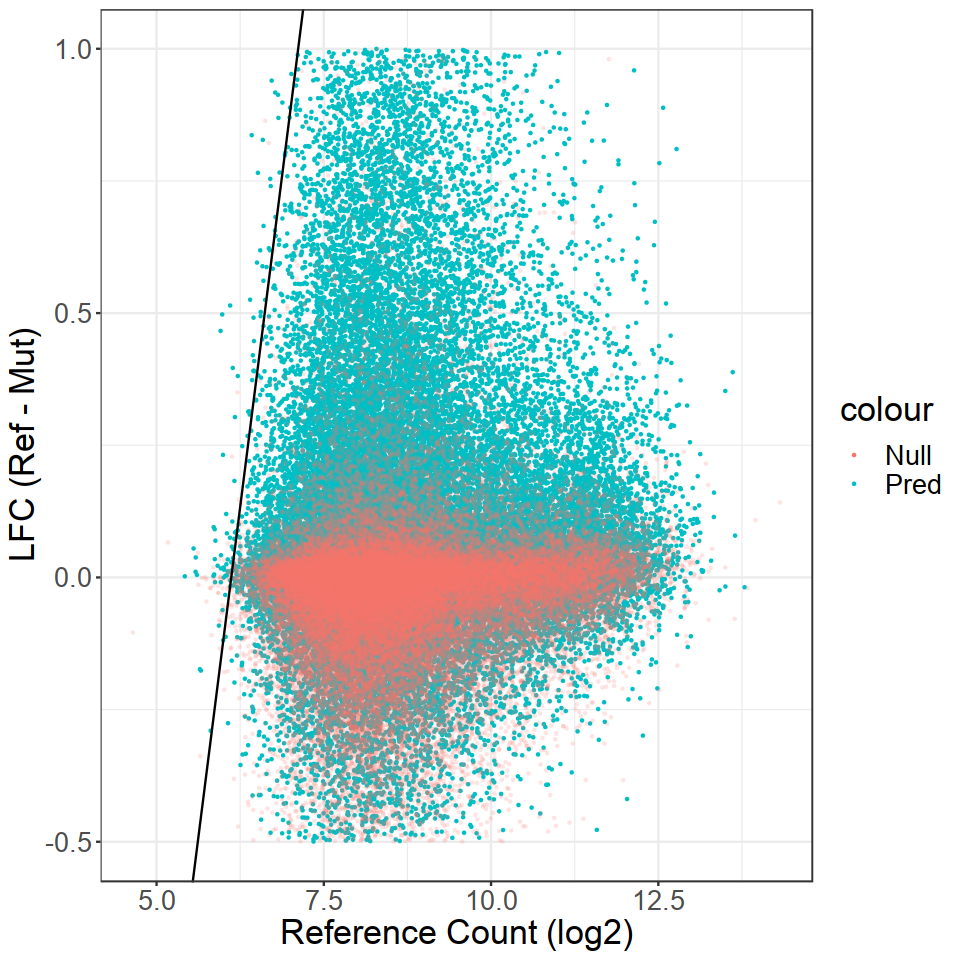

In [1276]:
options(repr.plot.width = 8, repr.plot.height = 8)

NSAMP = 50000
ggplot(motif_preds[sample(nrow(motif_preds), NSAMP), ]) + 
geom_point(aes(x=ref_task_0, y=ref_task_0-mut_task_0, colour='Pred'), stroke=0,  alpha=1, size=1) +
geom_point(data=null_preds[sample(nrow(null_preds), NSAMP), ], aes(x=ref_task_0, y=ref_task_0-mut_task_0, colour='Null'), 
                                                                   stroke=0, alpha=0.2, size=1) +
ylim(c(-0.5,1)) +
xlab("Reference Count (log2)") +
ylab("LFC (Ref - Mut)") +
geom_abline(slope=1, intercept = -quantile(motif_preds$ref_task_0, 0.001)) +
theme_bw() + 
theme(text = element_text(size=20))

### Peak x Motif Matrix for ChromVAR or similar

In [971]:
library(Matrix)


Attaching package: ‘Matrix’


The following object is masked from ‘package:S4Vectors’:

    expand




In [1278]:
all_peaks= import("../20200206_pmat_snapATAC/sessions/20200520_n68916/peaks.overlap.smallpeaks.bed")

In [1334]:
all_peaks

GRanges object with 803958 ranges and 0 metadata columns:
           seqnames              ranges strand
              <Rle>           <IRanges>  <Rle>
       [1]     chr1   97145605-97145864      *
       [2]     chr1     7538149-7538363      *
       [3]     chr1   93196679-93196894      *
       [4]     chr1 187577714-187577913      *
       [5]     chr1   53278066-53278265      *
       ...      ...                 ...    ...
  [803954]     chrY     7500308-7500509      *
  [803955]     chrY     7447985-7448191      *
  [803956]     chrY   14733641-14733856      *
  [803957]     chrY   12662453-12662752      *
  [803958]     chrY   12681581-12681865      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [1335]:
overlaps = findOverlaps(sig_pwm_hits, all_peaks, type='within')
overlaps

Hits object with 2924463 hits and 0 metadata columns:
            queryHits subjectHits
            <integer>   <integer>
        [1]         1      350235
        [2]         2      332569
        [3]         3      332569
        [4]         4      332569
        [5]         5      332569
        ...       ...         ...
  [2924459]   2924459      803885
  [2924460]   2924460      803885
  [2924461]   2924461      803438
  [2924462]   2924462      803438
  [2924463]   2924463      803438
  -------
  queryLength: 2924463 / subjectLength: 803958

In [1336]:
query_motif = sig_pwm_hits[queryHits(overlaps)]$name
query_motif = factor(query_motif)

In [1337]:
all_peaks_x_motif = sparseMatrix(i=subjectHits(overlaps),
                                 j=as.numeric(query_motif),
                                 dims=c(length(all_peaks), length(levels(query_motif))),
                                dimnames=list(as.character(all_peaks), levels(query_motif)))

In [1338]:
all_peaks_x_motif = as(all_peaks_x_motif, "dgCMatrix")

In [1339]:
writeMM(all_peaks_x_motif, 
        file="./bpnet_scores/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40/peaks.overlap.smallpeaks.hits.bpnet.01.mm")

write.table(levels(query_motif), 
            file="./bpnet_scores/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40/peaks.overlap.smallpeaks.hits.bpnet.01.motif.names.txt",
           quote=F, row.names=F, col.names=F)

NULL

### Pairwise Observed/Expected

In [1284]:
head(all_peaks_x_motif, 2)

   [[ suppressing 109 column names ‘AP-1(bZIP)’, ‘AP-2alpha(AP2)’, ‘AP-2gamma(AP2)’ ... ]]



2 x 109 sparse Matrix of class "dgCMatrix"
                                                                              
chr1:97145605-97145864 . . . . . . . . . . . . . . . . . . . . . . . . . . . .
chr1:7538149-7538363   1 . . . . 1 1 1 . 1 . . 1 1 . 1 . . 1 . . . . . . . . .
                                                                              
chr1:97145605-97145864 . . . . . . . . . . . . . . . . . . . . . . . . . . . .
chr1:7538149-7538363   . . 1 . . . 1 . . . . . . . . 1 1 1 . . . . . . . . . .
                                                                              
chr1:97145605-97145864 . . . . . . . . . . . . . . . . . . . . . . . . . . 1 1
chr1:7538149-7538363   . . . . . . . . . . . . . . . . . . . . . . . . . . . .
                                                                        
chr1:97145605-97145864 1 1 . . . . . . . . . . . . . . . . . . . . . . .
chr1:7538149-7538363   . . . . . . . . . . . . . . . . . . . . . . . . .

In [1285]:
t(ncol(all_peaks_x_motif)/colSums(all_peaks_x_motif))

AP-1(bZIP),AP-2alpha(AP2),AP-2gamma(AP2),Ap4(bHLH),Ascl2(bHLH),Atf1(bZIP),Atf2(bZIP),Atf3(bZIP),Atf4(bZIP),Atf7(bZIP),⋯,TEAD3(TEA),TEAD4(TEA),Tlx?(NR),WT1(Zf),X-box(HTH),YY1(Zf),ZBTB18(Zf),ZBTB33(Zf),Zic3(Zf),ZNF143|STAF(Zf)
0.0009539897,0.005503661,0.004698073,0.003431558,0.005281775,0.006515242,0.009854444,0.0009579807,0.01356396,0.007879708,⋯,0.003137774,0.00412957,0.006755082,0.008981543,0.0263285,0.1196487,0.007019126,0.2344086,0.008637084,0.0246272


In [1286]:
expected_jaccard = nrow(all_peaks_x_motif)/colSums(all_peaks_x_motif) %*% t(rep(1,ncol(all_peaks_x_motif)))
expected_jaccard = expected_jaccard +  (rep(1,ncol(all_peaks_x_motif)) %*% t(nrow(all_peaks_x_motif)/colSums(all_peaks_x_motif)))
expected_jaccard = 1/(expected_jaccard - 1)

rownames(expected_jaccard) = colnames(expected_jaccard)

In [1287]:
# symmetric?
all(expected_jaccard == t(expected_jaccard))

[1] TRUE

In [1288]:
# check 
1/(nrow(all_peaks_x_motif)/sum(all_peaks_x_motif[,"AP-1(bZIP)"]) + nrow(all_peaks_x_motif)/sum(all_peaks_x_motif[,"AP-2gamma(AP2)"]) -1)

[1] 0.02457711

In [1289]:
head(expected_jaccard, 2)

,AP-1(bZIP),AP-2alpha(AP2),AP-2gamma(AP2),Ap4(bHLH),Ascl2(bHLH),Atf1(bZIP),Atf2(bZIP),Atf3(bZIP),Atf4(bZIP),Atf7(bZIP),⋯,TEAD3(TEA),TEAD4(TEA),Tlx?(NR),WT1(Zf),X-box(HTH),YY1(Zf),ZBTB18(Zf),ZBTB33(Zf),Zic3(Zf),ZNF143|STAF(Zf)
AP-1(bZIP),0.07649470,0.02144538,0.02457711,0.03190123,0.02222542,0.01848727,0.012703183,0.07632284,0.009426763,0.01558719,⋯,0.03427020,0.02740092,0.01790181,0.013834681,0.004994278,0.001125446,0.0172987,0.0005763761,0.014338671,0.005328196
AP-2alpha(AP2),0.02144538,0.01247079,0.01346882,0.01540736,0.01273061,0.01140920,0.008906487,0.02143185,0.007161362,0.01023410,⋯,0.01593952,0.01427503,0.01118349,0.009448277,0.004277408,0.001084488,0.0109451,0.0005654396,0.009680658,0.004520018


In [1290]:
observed_intersection = t(all_peaks_x_motif) %*% all_peaks_x_motif
observed_union = (colSums(all_peaks_x_motif) %*% t(rep(1,ncol(all_peaks_x_motif)))) + 
                 (rep(1,ncol(all_peaks_x_motif)) %*% t(colSums(all_peaks_x_motif))) -
                 observed_intersection 

In [1291]:
observed_jaccard = as.matrix(observed_intersection/observed_union)

In [1292]:
# check 
example_int = sum(all_peaks_x_motif[,"AP-1(bZIP)"]*all_peaks_x_motif[,"AP-2gamma(AP2)"])
example_int/(sum(all_peaks_x_motif[,"AP-1(bZIP)"])+sum(all_peaks_x_motif[,"AP-2gamma(AP2)"]) - example_int)

[1] 0.02483467

In [1293]:
head(as.matrix(observed_jaccard), 2)

,AP-1(bZIP),AP-2alpha(AP2),AP-2gamma(AP2),Ap4(bHLH),Ascl2(bHLH),Atf1(bZIP),Atf2(bZIP),Atf3(bZIP),Atf4(bZIP),Atf7(bZIP),⋯,TEAD3(TEA),TEAD4(TEA),Tlx?(NR),WT1(Zf),X-box(HTH),YY1(Zf),ZBTB18(Zf),ZBTB33(Zf),Zic3(Zf),ZNF143|STAF(Zf)
AP-1(bZIP),1.00000000,0.02147146,0.02483467,0.06353334,0.03194663,0.03125566,0.02026394,0.89965179,0.017361862,0.02601689,⋯,0.05969332,0.04623761,0.02334032,0.01671560,0.005306864,0.0005560189,0.02974523,0.0001918047,0.01755582,0.006905972
AP-2alpha(AP2),0.02147146,1.00000000,0.77307772,0.02563644,0.02543168,0.01669681,0.01402806,0.02144807,0.007017036,0.01545614,⋯,0.03217077,0.03267915,0.02553786,0.02661267,0.005627651,0.0013050413,0.01663022,0.0005429686,0.02116335,0.012409125


In [1294]:
ooe_jaccard = observed_jaccard/expected_jaccard
diag(ooe_jaccard) = 1
head(ooe_jaccard)

,AP-1(bZIP),AP-2alpha(AP2),AP-2gamma(AP2),Ap4(bHLH),Ascl2(bHLH),Atf1(bZIP),Atf2(bZIP),Atf3(bZIP),Atf4(bZIP),Atf7(bZIP),⋯,TEAD3(TEA),TEAD4(TEA),Tlx?(NR),WT1(Zf),X-box(HTH),YY1(Zf),ZBTB18(Zf),ZBTB33(Zf),Zic3(Zf),ZNF143|STAF(Zf)
AP-1(bZIP),1.000000,1.001216,1.010480,1.991564,1.437391,1.690658,1.595186,11.787451,1.8417628,1.669120,⋯,1.741844,1.687447,1.303797,1.208239,1.062589,0.4940433,1.719506,0.3327770,1.224369,1.296118
AP-2alpha(AP2),1.001216,1.000000,57.397586,1.663908,1.997679,1.463452,1.575038,1.000757,0.9798466,1.510258,⋯,2.018303,2.289254,2.283534,2.816669,1.315669,1.2033711,1.519422,0.9602592,2.186148,2.745371
AP-2gamma(AP2),1.010480,57.397586,1.000000,1.679182,2.054007,1.311882,1.370616,1.011378,1.0177851,1.334966,⋯,2.007491,2.250574,2.354287,2.900346,1.391802,1.2555766,1.563196,1.4908177,2.124545,2.754542
Ap4(bHLH),1.991564,1.663908,1.679182,1.000000,25.771544,2.520167,2.487929,1.964548,2.2392534,2.488091,⋯,2.221504,2.268396,2.971550,2.290497,2.144778,1.3619118,18.498966,0.9252853,6.173282,1.866312
Ascl2(bHLH),1.437391,1.997679,2.054007,25.771544,1.000000,2.069624,1.921137,1.407939,1.9177742,1.939263,⋯,1.996312,2.054228,2.984119,2.264290,2.117931,1.7547201,19.124345,1.1730172,7.064960,1.962543
Atf1(bZIP),1.690658,1.463452,1.311882,2.520167,2.069624,1.000000,59.331419,1.678539,17.6929190,61.688011,⋯,2.195676,2.211030,1.706784,1.608230,2.511171,2.5891437,2.275326,2.4823204,1.623530,1.742802


In [1295]:
# NB: apart from highly similar motifs, some may be inflated since the model will only pick them up in peaks of states in which that motif is bound
# e.g. TFs that kick in only in the final state will appear to co-occur simply because the model will pick it up in peaks of the last state only
MOTIF = "Klf4(Zf)"
head(ooe_jaccard[,MOTIF][rev(order(ooe_jaccard[,MOTIF]))], 10)

EKLF(Zf)        KLF1(Zf)        KLF5(Zf)       KLF14(Zf)         Sp1(Zf) 
      31.969007       14.560245       12.453780        9.528750        8.886140 
        Sp2(Zf)         Sp5(Zf)         WT1(Zf) ZNF143|STAF(Zf)  AP-2gamma(AP2) 
       8.824693        7.482393        2.786082        2.615552        2.503159

In [1296]:
ooe_tf_to_plot = colSums(all_peaks_x_motif[,rownames(ooe_jaccard)])>5000
ooe_to_plot = ooe_jaccard[ooe_tf_to_plot, ooe_tf_to_plot]

dim(ooe_to_plot)

[1] 84 84

In [1297]:
rownames(ooe_to_plot) = get_tf_fam(rownames(ooe_to_plot))[[1]]
colnames(ooe_to_plot) = rownames(ooe_to_plot)

In [1298]:
dd <- dist(scale(log(1+ooe_to_plot)), method = "euclidean")
hc <- hclust(dd, method = "ward.D2")

In [1299]:
ooe_to_plot = ooe_to_plot[hc$order, rev(hc$order)]

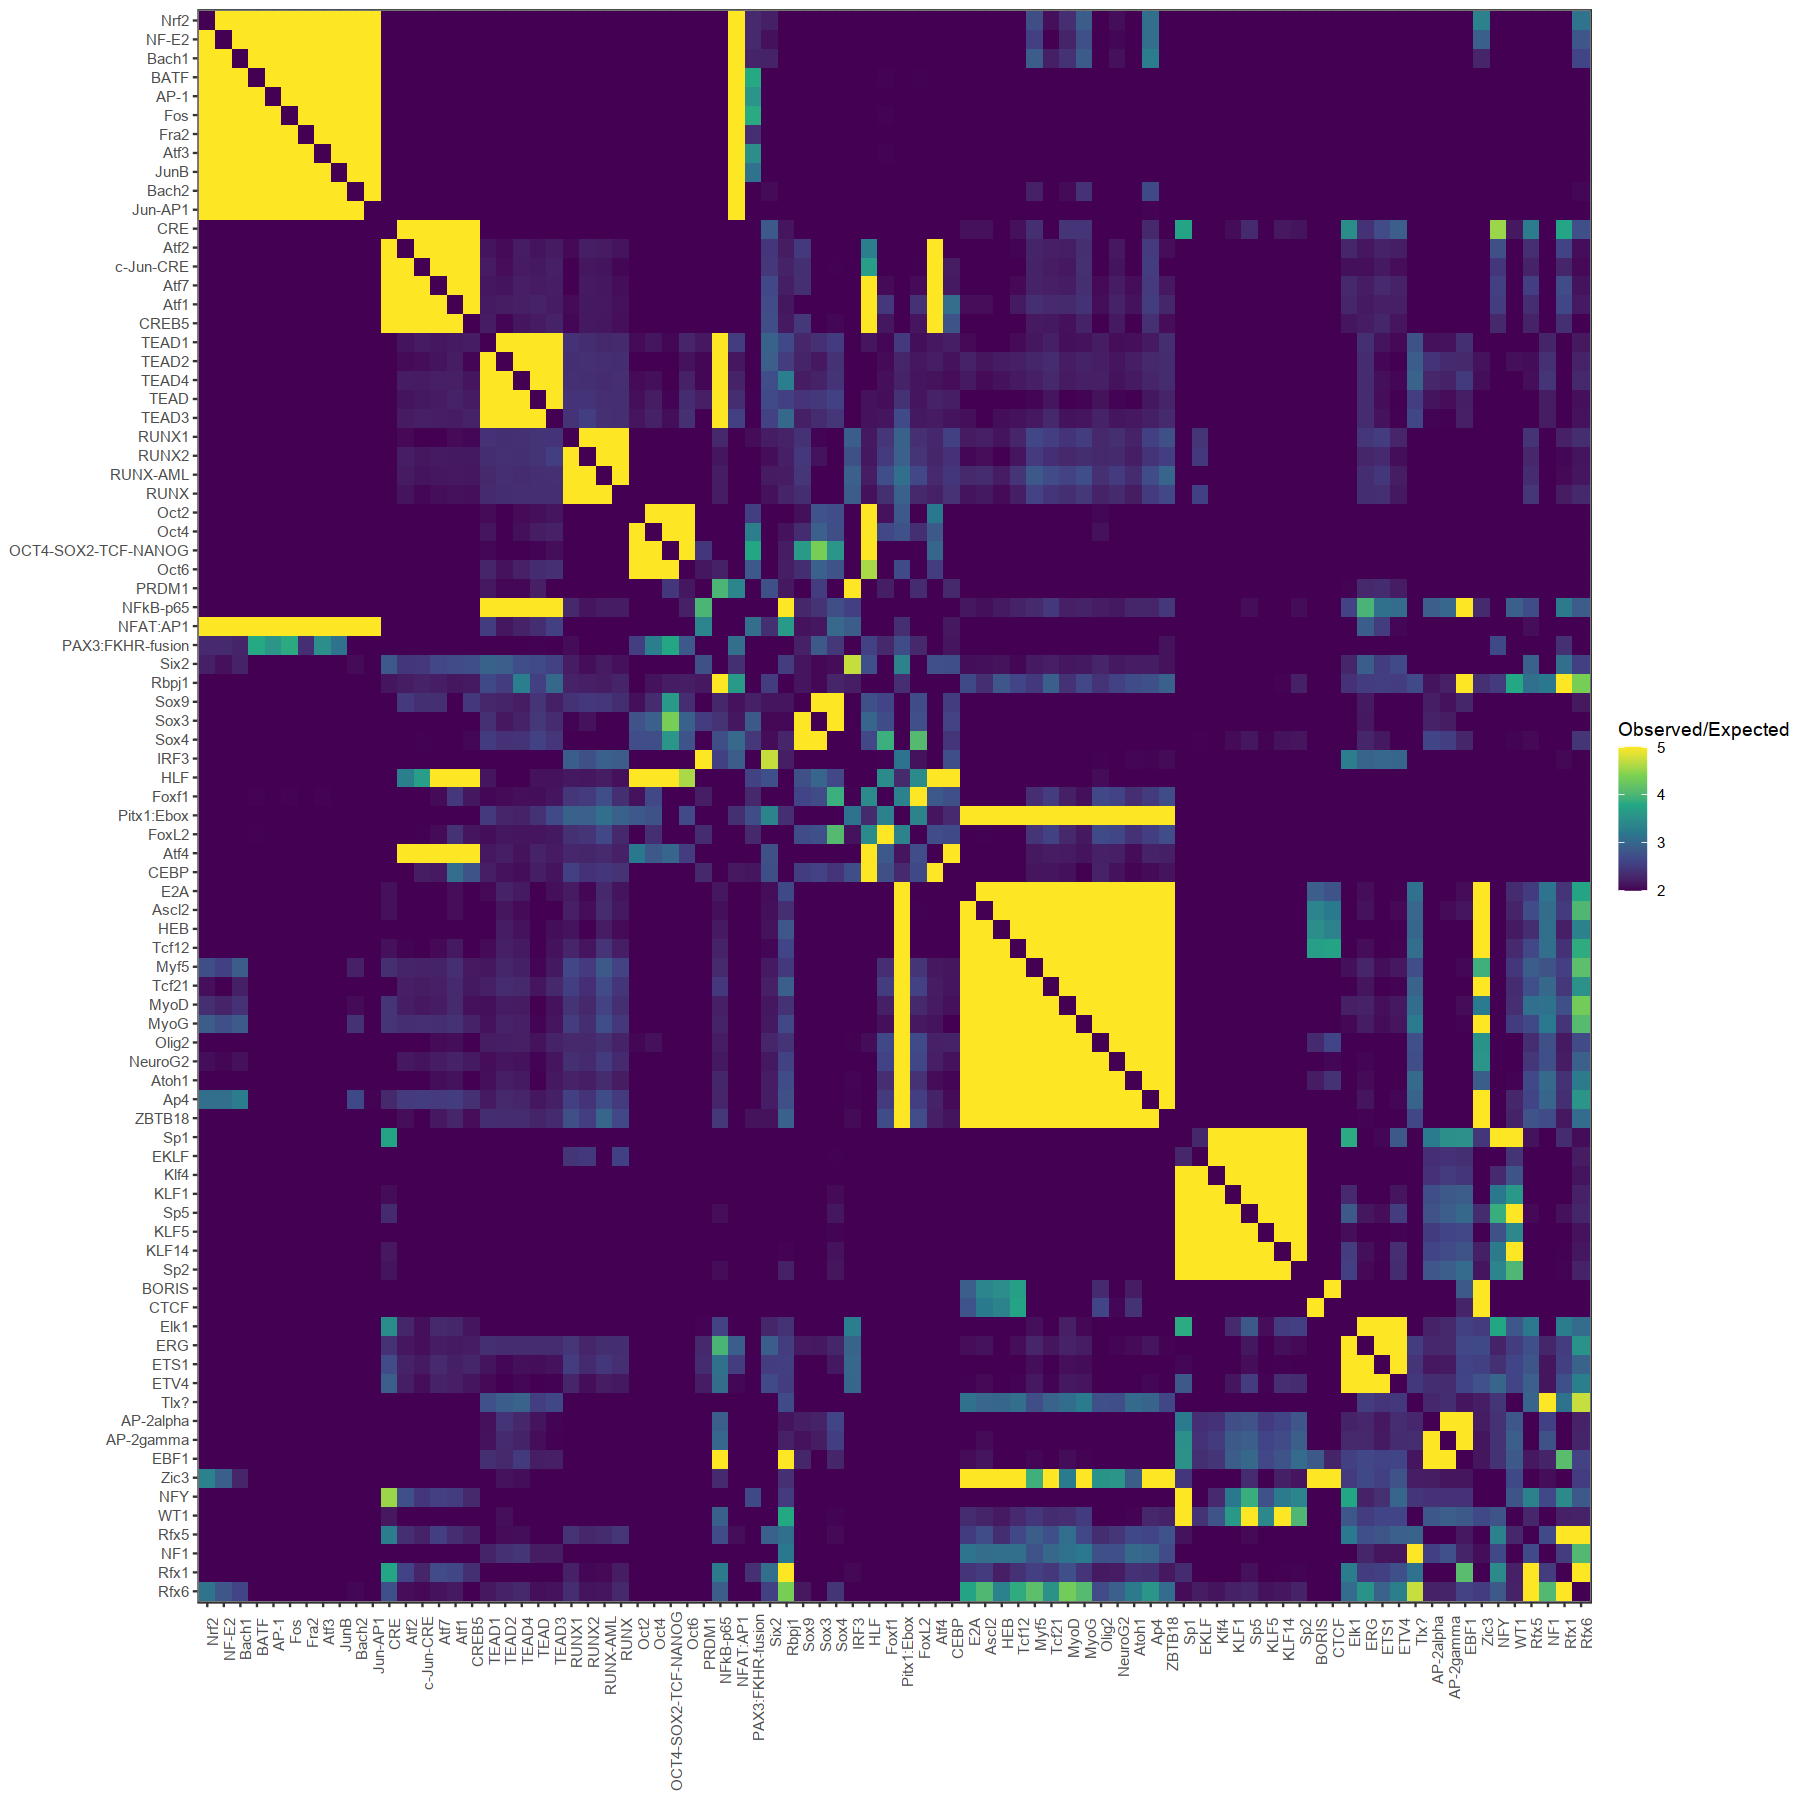

In [1300]:
options(repr.plot.width = 15, repr.plot.height = 15)

ggplot(melt(ooe_to_plot)) +
geom_tile(aes(x=Var1, y=Var2, fill=value)) +
scale_fill_viridis_c(limits=c(2, 5),
                      oob=squish,
                      name="Observed/Expected") +
theme_bw() +
theme(axis.text.x = element_text(angle = 90, hjust=0.95),
     axis.title.x= element_blank(),
     axis.title.y= element_blank())

### TFAP2 Co-binding

In [1344]:
pre_ipsc_peaks_gr = import("/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/clusters/20200518_n76052/croo/cluster_idx2/peak/overlap_reproducibility/overlap.optimal_peak.narrowPeak.gz")
head(pre_ipsc_peaks_gr,2)

GRanges object with 2 ranges and 6 metadata columns:
      seqnames              ranges strand |        name     score signalValue
         <Rle>           <IRanges>  <Rle> | <character> <numeric>   <numeric>
  [1]     chr1 100006395-100006725      * | Peak_245549        92     3.83773
  [2]     chr1 100028131-100029350      * | Peak_189947       142     4.87097
         pValue    qValue      peak
      <numeric> <numeric> <integer>
  [1]   9.21016   7.44557       220
  [2]  14.23553  12.34985      1091
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [1363]:
overlap = findOverlaps(sig_pwm_hits, pre_ipsc_peaks_gr)
pre_ipsc_sig_pwm_hits = sig_pwm_hits[unique(queryHits(overlap))]
pre_ipsc_sig_pwm_hits

GRanges object with 1196138 ranges and 2 metadata columns:
            seqnames              ranges strand |           name     score
               <Rle>           <IRanges>  <Rle> |    <character> <numeric>
        [1]    chr10 100009944-100009955      - |     Atf3(bZIP)  9.009951
        [2]    chr10 100009944-100009955      + |     Fra2(bZIP)  8.838653
        [3]    chr10 100009944-100009955      - |  Jun-AP1(bZIP)  9.288066
        [4]    chr10 100009945-100009956      - |      Fos(bZIP)  8.082073
        [5]    chr10 100009945-100009954      + |     BATF(bZIP)   8.61079
        ...      ...                 ...    ... .            ...       ...
  [1196134]     chrY     8305268-8305279      + | AP-2alpha(AP2)   7.40311
  [1196135]     chrY     8305271-8305282      + | AP-2gamma(AP2)  8.345038
  [1196136]     chrY     9775858-9775867      - |      HEB(bHLH)  6.201509
  [1196137]     chrY     9775867-9775886      - |       CTCF(Zf)  9.490907
  [1196138]     chrY     9775869-9775888 

In [1369]:
ap2_hits = pre_ipsc_sig_pwm_hits[pre_ipsc_sig_pwm_hits$name=="AP-2gamma(AP2)"]
non_ap2_hits = pre_ipsc_sig_pwm_hits[pre_ipsc_sig_pwm_hits$name!="AP-2gamma(AP2)"]

length(ap2_hits)
length(non_ap2_hits)

# also remove AP-2alpha(AP2)
non_ap2_hits = non_ap2_hits[non_ap2_hits$name!="AP-2alpha(AP2)"]
length(non_ap2_hits)

[1] 18621

[1] 1177517

[1] 1161421

In [1385]:
get_ngb_counts <- function(fg_motifs, bg_motifs, window=100) {
    fg_plus_window_overlaps = unique(queryHits(findOverlaps(bg_motifs, fg_motifs+window)))
    fg_overlap = unique(queryHits(findOverlaps(bg_motifs, fg_motifs)))
    
    fg_plus_window_overlaps = fg_plus_window_overlaps[!fg_plus_window_overlaps %in% fg_overlap]
    
    bg_motifs[fg_plus_window_overlaps]$name
}

In [1386]:
# does not work since motif hits are structured
# shuf_non_ap2_hits = non_ap2_hits
# shuf_non_ap2_hits$name = sample(shuf_non_ap2_hits$name)
# shuf_non_ap2_hits

shuf_ap2_hits = non_ap2_hits[sample(seq(length(non_ap2_hits)), length(ap2_hits))]
shuf_ap2_hits

GRanges object with 18621 ranges and 2 metadata columns:
          seqnames              ranges strand |        name     score
             <Rle>           <IRanges>  <Rle> | <character> <numeric>
      [1]     chr9 133738406-133738417      - |     Sp1(Zf)  9.031086
      [2]    chr12   12745741-12745750      - |  AP-1(bZIP)  9.657636
      [3]    chr18   69129360-69129369      + |    KLF5(Zf)  7.699553
      [4]    chr19   43318359-43318370      - |  Fra2(bZIP)  8.806748
      [5]     chr6 116144748-116144757      - |   Elk1(ETS)  7.382532
      ...      ...                 ...    ... .         ...       ...
  [18617]    chr12 103930815-103930826      - |     Sp2(Zf) 10.581083
  [18618]    chr18   63891080-63891089      + |  TEAD4(TEA)   7.55342
  [18619]    chr16     3065317-3065328      - | Atoh1(bHLH)  9.865583
  [18620]     chr4 147867060-147867067      + |   Sox3(HMG)  6.906595
  [18621]     chr8   27774434-27774445      + |     Sp5(Zf) 12.218451
  -------
  seqinfo: 24 sequences

In [1387]:
shuf_counts = table(get_ngb_counts(shuf_ap2_hits, non_ap2_hits))
actual_counts = table(get_ngb_counts(ap2_hits, non_ap2_hits))

In [1392]:
actual_counts["PRDM1(Zf)"]
shuf_counts["PRDM1(Zf)"]

PRDM1(Zf) 
      115

PRDM1(Zf) 
       49

In [1389]:
ove = actual_counts/shuf_counts
rev(sort(ove))


                            PRDM1(Zf)                         REST-NRSF(Zf) 
                            2.3469388                             1.5833333 
                OCT:OCT(POU,Homeobox)                        Six4(Homeobox) 
                            1.3750000                             1.3157895 
                           GRHL2(CP2)     PAX3:FKHR-fusion(Paired,Homeobox) 
                            1.2653061                             1.2539683 
                          NF-E2(bZIP)                             Sox3(HMG) 
                            1.2315789                             1.2305665 
                   NFAT:AP1(RHD,bZIP)                             Sox4(HMG) 
                            1.2000000                             1.1877256 
                          TEAD1(TEAD)                           Bach1(bZIP) 
                            1.1627057                             1.1458333 
                           TEAD4(TEA)                            Nrf2(bZIP)

### Concordance between PWM scores and BPNet hits

In [810]:
library(PRROC)

In [1321]:
auprcs = list()
aucs = list()
frac_pos = list()

for (motif in unique(pwm_hits$name)) {
    motif_bpnet_hits = sig_pwm_hits[sig_pwm_hits$name==motif]
    motif_pwm_hits = pwm_hits[pwm_hits$name==motif]
    
    frac_pos[[motif]] = length(motif_bpnet_hits)/length(motif_pwm_hits)
    
    labels = as.character(motif_pwm_hits) %in% as.character(motif_bpnet_hits)    
    
    aucs[[motif]] = roc.curve(scores.class0 = motif_pwm_hits$score[labels==T], 
                       scores.class1 = motif_pwm_hits$score[labels==F], curve=T)
    
    auprcs[[motif]] = pr.curve(scores.class0 = motif_pwm_hits$score[labels==T], 
                scores.class1 = motif_pwm_hits$score[labels==F], curve=T)
}

In [1322]:
motif_auc_df = data.frame(motif=names(lapply(aucs, "[[", "auc")),
                          auc=as.vector(unlist(lapply(aucs, "[[", "auc"))),
                          auprc=as.vector(unlist(lapply(auprcs, "[[", "auc.davis.goadrich"))))
motif_auc_df = motif_auc_df[order(motif_auc_df$auc), ]
motif_auc_df$motif = factor(motif_auc_df$motif,
                           levels=motif_auc_df$motif)
motif_auc_df$frp = unlist(frac_pos[as.character(motif_auc_df$motif)])
head(motif_auc_df)

,motif,auc,auprc,frp
,<fct>,<dbl>,<dbl>,<dbl>
2,Sox4(HMG),0.4848268,0.1506341,0.1526874
108,"FOXA1:AR(Forkhead,NR)",0.4897095,0.1640767,0.1697919
33,Ap4(bHLH),0.5048599,0.2736679,0.2404771
60,Ascl2(bHLH),0.5105156,0.1848332,0.1793897
34,Tcf21(bHLH),0.5163241,0.3173388,0.2887043
40,Sp1(Zf),0.5168733,0.5403713,0.5321024


In [1323]:
motif_auc_df[grep("gamma", motif_auc_df$motif), ]

,motif,auc,auprc,frp
,<fct>,<dbl>,<dbl>,<dbl>
43,AP-2gamma(AP2),0.627256,0.317937,0.1972686


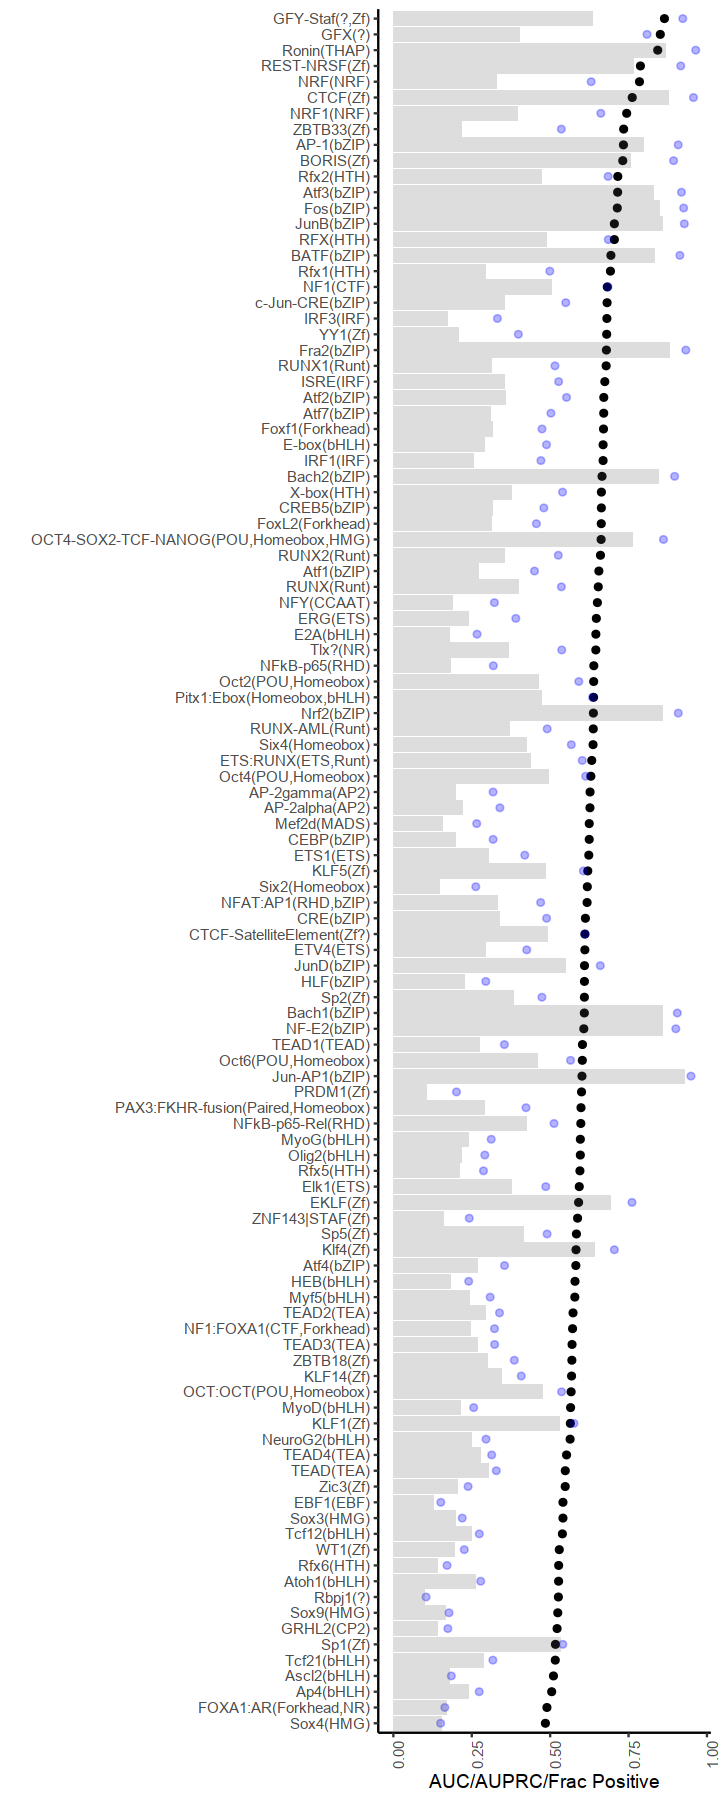

In [1324]:
options(repr.plot.width = 6, repr.plot.height = 15)

ggplot(motif_auc_df) +
geom_point(aes(x=motif, y=auc)) + 
geom_point(aes(x=motif, y=auprc), alpha=0.3, colour='blue') + 
geom_bar(aes(x=motif, y=frp), alpha=0.2, stat="identity") +
ylab("AUC/AUPRC/Frac Positive") +
xlab("") +
coord_flip() +
theme_classic() +
theme(axis.text.x = element_text(angle = 90, hjust=0.95)) 

In [1325]:
MOTIF = "nfy"
names(aucs)[grep(MOTIF, names(aucs), ignore.case=T)]

MOTIF = names(aucs)[grep(MOTIF, names(aucs), ignore.case=T)][1]
MOTIF

[1] "NFY(CCAAT)"

[1] "NFY(CCAAT)"

[1] 18.97141

[1] 8

[1] 66

[1] 535

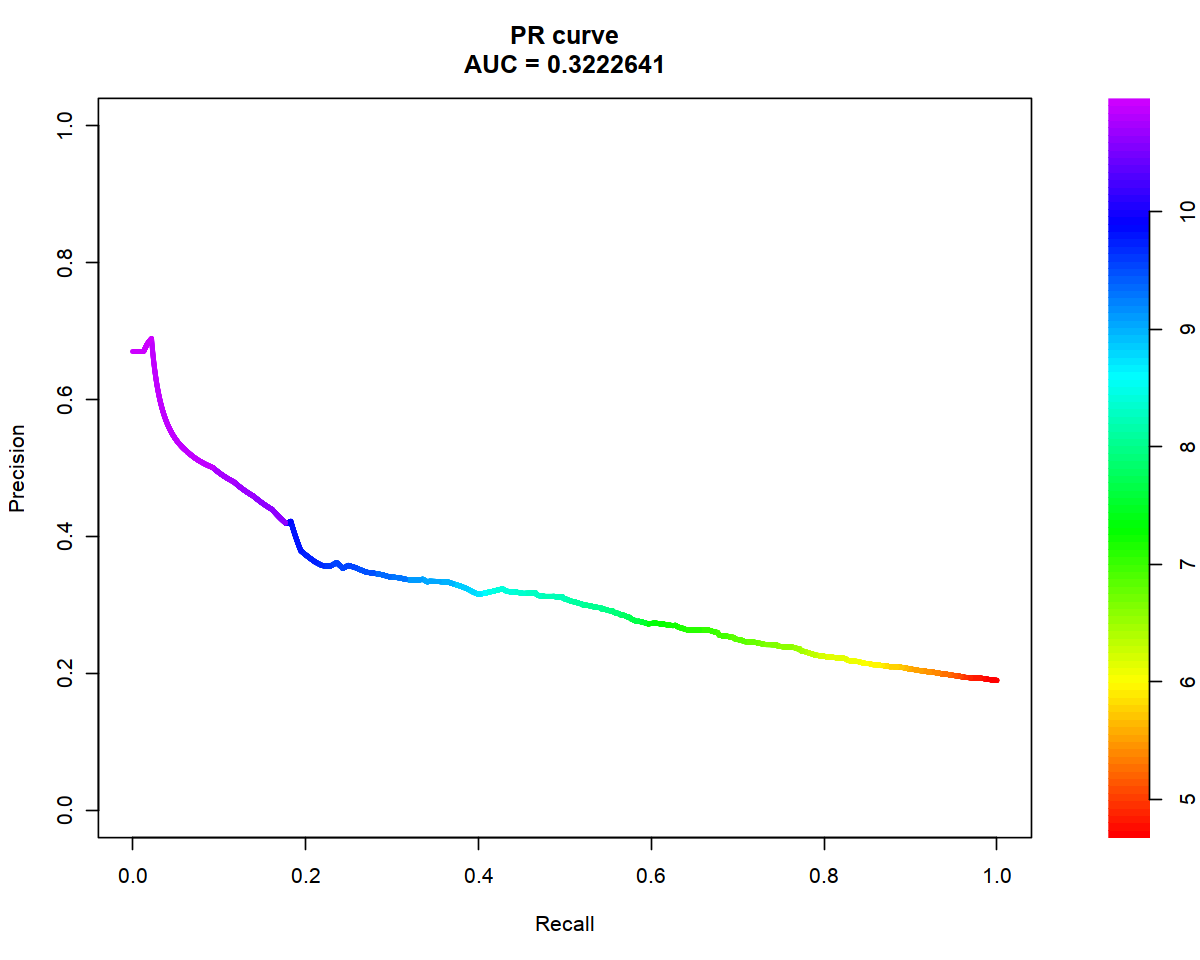

In [1326]:
motif_bpnet_hits = as.character(sig_pwm_hits[sig_pwm_hits$name==MOTIF])
motif_pwm_hits = pwm_hits[pwm_hits$name==MOTIF]
motif_pwm_hits = as.character(motif_pwm_hits[rev(order(motif_pwm_hits$score))])

100*frac_pos[[MOTIF]]

# hits at top 10, 100, 1000
sum(motif_pwm_hits[1:10] %in% motif_bpnet_hits)
sum(motif_pwm_hits[1:100] %in% motif_bpnet_hits)
sum(motif_pwm_hits[1:1000] %in% motif_bpnet_hits)

options(repr.plot.width = 10, repr.plot.height = 8)

plot(auprcs[[MOTIF]])

## Peak Set x Motif Breakdown

In [1301]:
peak_x_motif_counts = matrix(0, nrow=length(PEAK_SET_BEDS), 
                                 ncol=length(unique(sig_pwm_hits$name)))
rownames(peak_x_motif_counts) = PEAK_SET_NAMES
colnames(peak_x_motif_counts) = unique(sig_pwm_hits$name)

In [1302]:
NUM_PEAKS = list()

In [1303]:
for (i in seq(length(PEAK_SET_BEDS))) {
    cur_peak_set = import(PEAK_SET_BEDS[[i]])
    NUM_PEAKS[[PEAK_SET_NAMES[[i]]]] = length(cur_peak_set)
    
    # allows counting multiple hits per peak
    cur_motif_counts = table(sig_pwm_hits[queryHits(findOverlaps(sig_pwm_hits, cur_peak_set, type='within'))]$name)
    
    peak_x_motif_counts[PEAK_SET_NAMES[[i]], names(cur_motif_counts)] = cur_motif_counts
}

In [1304]:
head(peak_x_motif_counts)

,Rfx6(HTH),"Pitx1:Ebox(Homeobox,bHLH)",Atf3(bZIP),Fos(bZIP),AP-1(bZIP),BATF(bZIP),JunB(bZIP),Olig2(bHLH),Jun-AP1(bZIP),Fra2(bZIP),⋯,CRE(bZIP),Nrf2(bZIP),CREB5(bZIP),JunD(bZIP),Six4(Homeobox),"FOXA1:AR(Forkhead,NR)",YY1(Zf),CTCF-SatelliteElement(Zf?),ISRE(IRF),"NF1:FOXA1(CTF,Forkhead)"
idx1,167,283,4389,4225,4347,4276,3894,844,2124,3604,⋯,50,245,259,79,6,19,1,6,70,30
idx2,347,622,4813,4498,4829,4721,4169,2666,2012,3765,⋯,164,331,952,345,51,75,2,4,375,104
idx3,229,320,12171,11615,12083,11916,10776,867,5348,9709,⋯,152,624,566,203,16,31,2,5,79,28
idx4,673,860,14053,13307,14073,13632,12415,2948,6679,11364,⋯,308,909,1123,381,79,57,10,8,175,134
idx5,535,777,13742,12995,13594,13389,12091,2485,6074,10957,⋯,250,808,1104,359,64,73,12,9,278,115
idx6,649,750,5070,4827,5094,4882,4488,3101,2671,4171,⋯,237,423,801,309,152,34,8,18,259,67


In [1305]:
# filter
MIN_TOTAL_HITS = 5000
peak_x_motif_norm = peak_x_motif_counts[, colSums(peak_x_motif_counts)>MIN_TOTAL_HITS]

# row norm
peak_x_motif_norm = peak_x_motif_norm/rowSums(peak_x_motif_norm)

# col norm by total number of peaks in peakset
# may show higher counts for peak sets part of multiple cell states 
# which would as a result have more called motifs
# peak_x_motif_norm = t(t(peak_x_motif_norm)/unlist(NUM_PEAKS[rownames(peak_x_motif_counts)]))

# column norm to 0-1
peak_x_motif_norm = t(t(peak_x_motif_norm) - colMins(peak_x_motif_norm))
peak_x_motif_norm = t(t(peak_x_motif_norm)/colMaxs(peak_x_motif_norm))
head(peak_x_motif_norm)

,Rfx6(HTH),"Pitx1:Ebox(Homeobox,bHLH)",Atf3(bZIP),Fos(bZIP),AP-1(bZIP),BATF(bZIP),JunB(bZIP),Olig2(bHLH),Jun-AP1(bZIP),Fra2(bZIP),⋯,Atf4(bZIP),Atf2(bZIP),Atf7(bZIP),Six2(Homeobox),Bach1(bZIP),c-Jun-CRE(bZIP),PRDM1(Zf),CRE(bZIP),Nrf2(bZIP),CREB5(bZIP)
idx1,0.1765534,0.4337875,0.7087507,0.7151288,0.7062933,0.7047360,0.7090452,0.41193178,0.7809720,0.7295371,⋯,0.3407891,0.3164464,0.3256303,0.1337796,0.9113712,0.3535945,0.26806316,0.05592866,0.7550059,0.3611126
idx2,0.3136565,0.5861135,0.4463098,0.4352375,0.4504638,0.4467768,0.4328403,0.98816442,0.4067052,0.4328500,⋯,1.0000000,1.0000000,1.0000000,0.4092160,0.6413590,1.0000000,1.00000000,0.15904273,0.5813106,1.0000000
idx3,0.0000000,0.2247818,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,0.09726559,1.0000000,1.0000000,⋯,0.1430929,0.4293726,0.4098234,0.1740897,1.0000000,0.4549800,0.09527406,0.11049069,1.0000000,0.4072869
idx4,0.3119531,0.4041113,0.6996858,0.6934705,0.7056454,0.6924424,0.6966715,0.46213031,0.7553850,0.7081933,⋯,0.3350351,0.5980177,0.5701319,0.3753283,0.8303990,0.6199095,0.17064100,0.15190395,0.8881124,0.5403267
idx5,0.2268722,0.4025761,0.7593067,0.7515999,0.7558506,0.7551371,0.7531019,0.41342553,0.7580056,0.7573462,⋯,0.4448216,0.5910584,0.5713275,0.3253760,0.8767208,0.6154766,0.34272524,0.13070765,0.8675942,0.6001549
idx6,0.6786541,0.5763226,0.3756333,0.3739309,0.3794955,0.3679295,0.3727534,0.92676430,0.4480418,0.3852443,⋯,0.3283158,0.7005852,0.6919865,0.5774859,0.5666196,0.6874022,0.50464720,0.19674526,0.6135720,0.6340978


In [1306]:
dim(peak_x_motif_norm)

[1] 40 84

In [1307]:
all(colMins(peak_x_motif_norm)==0)
all(colMaxs(peak_x_motif_norm)==1)

[1] TRUE

[1] TRUE

## Plot

In [1308]:
to_plot_df = melt(peak_x_motif_norm)

to_plot_df$peak_set_idx = factor(sub("idx", "", as.character(to_plot_df$Var1)),
                                   levels=as.character(rev(sort(as.numeric(sub("idx", "", as.character(unique(to_plot_df$Var1))))))))
to_plot_df$score = to_plot_df$value

df_tf_fam = get_tf_fam(to_plot_df$Var2)
to_plot_df$TF = df_tf_fam[[1]]
to_plot_df$TF_family = df_tf_fam[[2]]

# separate KLF into its own family (current it's with ZF)
to_plot_df$TF_family[grep("KLF", to_plot_df$TF, ignore.case = T)] = "KLF"

In [1309]:
head(to_plot_df, 2)

,Var1,Var2,value,peak_set_idx,score,TF,TF_family
,<fct>,<fct>,<dbl>,<fct>,<dbl>,<chr>,<chr>
1,idx1,Rfx6(HTH),0.1765534,1,0.1765534,Rfx6,HTH
2,idx2,Rfx6(HTH),0.3136565,2,0.3136565,Rfx6,HTH


In [1310]:
# total counts of motifs
tot_motif_count = colSums(peak_x_motif_counts)
names(tot_motif_count) = get_tf_fam(names(tot_motif_count))[[1]]

In [1311]:
# remove highly correlated TFs per family
# https://stackoverflow.com/questions/18275639/remove-highly-correlated-variables

REMOVE_ABOVE = 0.95

keep_TFs = c()
for (x in unique(to_plot_df$TF_family)) {
    cur_tf_df = to_plot_df[to_plot_df$TF_family==x, c("score", "TF", "peak_set_idx")]
    if (length(unique(cur_tf_df$TF))==1) {
        keep_TFs = c(keep_TFs, unique(cur_tf_df$TF))
        next 
    }
    
    # make TF x sample matrix 
    tf_sample_matrix = matrix(0, nrow=length(unique(cur_tf_df$TF)), ncol=length(unique(cur_tf_df$peak_set_idx)))
    rownames(tf_sample_matrix) = unique(cur_tf_df$TF)
    colnames(tf_sample_matrix) = unique(cur_tf_df$sample)
    
    for (i in seq(1, dim(cur_tf_df)[1])) {
        tf_sample_matrix[cur_tf_df[i, "TF"], cur_tf_df[i, "peak_set_idx"]] = cur_tf_df[i, "score"]
    }
    
    # reorder TFs to bring those with most raw count up
    tf_sample_matrix = tf_sample_matrix[rev(order(tot_motif_count[rownames(tf_sample_matrix)])), ]
    
    # remove those with high correlation to another
    tf_cor = cor(t(tf_sample_matrix), method='spearman')
    tf_cor[upper.tri(tf_cor)] <- 0
    diag(tf_cor) <- 0
    keep_TFs = c(keep_TFs, 
                 rownames(tf_cor)[!apply(tf_cor,1,function(x) any(x > REMOVE_ABOVE))])

}

length(keep_TFs)

[1] 43

In [1312]:
to_plot_df = to_plot_df[to_plot_df$TF %in% keep_TFs, ]
dim(to_plot_df)
length(unique(to_plot_df$TF))

[1] 1720    7

[1] 43

In [1313]:
TF_family_order = c('POU,Homeobox', 
                    'POU,Homeobox,HMG', 
                    'HMG', 
                    'KLF', 
                    'bZIP', 
                    'Zf', 
                    'AP2', 
                    'TEA',
                    'Runt',
                    'ETS',
                    'CCAAT')
TF_family_order = c(TF_family_order, as.character(unique(to_plot_df$TF_family))[!as.character(unique(to_plot_df$TF_family)) %in% TF_family_order])

to_plot_df$TF_family = factor(to_plot_df$TF_family,
                                  level=TF_family_order)

In [1314]:
# remove SeqBias and Unknown and GFY/GFX
to_plot_df = to_plot_df[!grepl("(SeqBias|Unknown|GFY|GFX)", to_plot_df$TF) ,]
length(unique(to_plot_df$TF))

[1] 43

In [1315]:
quantile(to_plot_df$value, c(0, 0.1, 0.5, 0.9, 0.99, 1))

0%        10%        50%        90%        99%       100% 
0.00000000 0.02927405 0.27883024 0.73114821 1.00000000 1.00000000

In [1316]:
# https://dmitrijskass.netlify.app/2019/06/30/multi-level-labels-with-ggplot2/
# https://www.r-graph-gallery.com/320-the-basis-of-bubble-plot.html
p <- ggplot(to_plot_df, aes(x = TF, 
                            y = peak_set_idx, 
                            fill=score)) +
geom_tile() +
facet_grid(~factor(TF_family), #, levels=sample(unique(consolidated_df$TF_family))),
           scales = "free_x",
          space = "free_x") +
#           switch = "x") +
scale_fill_gradient(low="white",
                      high="red",
                      limits=c(0.05, 1),
                      oob=squish,
                      name="TF Score") +
ylab("") +
theme_classic() +
theme(axis.text.x = element_text(angle = 90, hjust=0.95), # rotate TF text
     strip.text.x.top = element_text(angle = 90, hjust=0, vjust=0.5), # rotate TF family text
     panel.spacing = unit(0.2, "lines"), # space between TF families
     text = element_text(size=15), 
     strip.background = element_blank(),
     panel.background = element_rect(fill = NA, color = "black", size=1)) # box around TF families

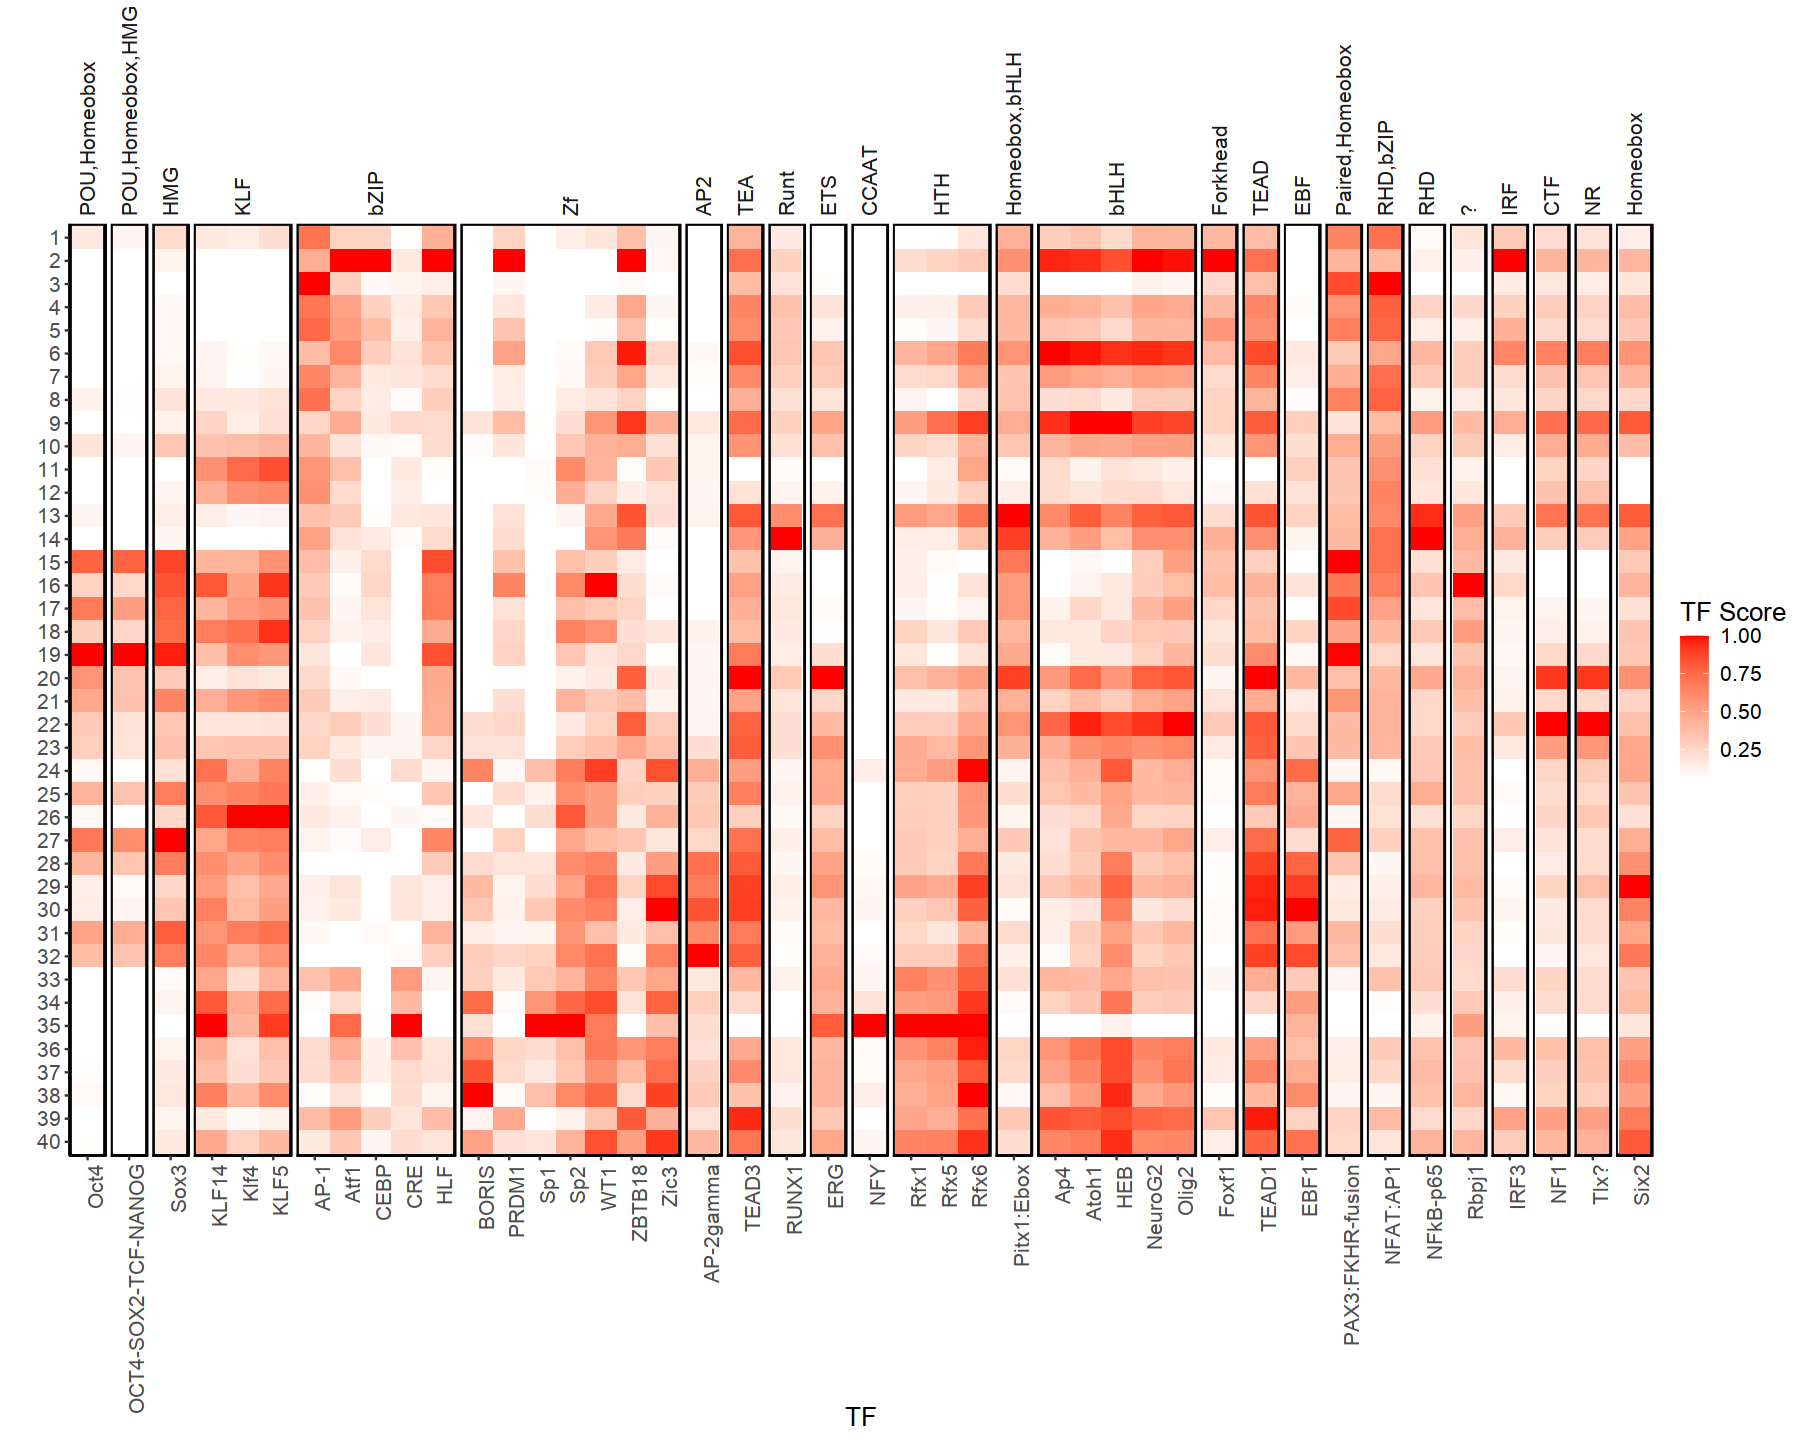

In [1317]:
options(repr.plot.width = 15, repr.plot.height = 12)


pg <- ggplotGrob(p)

# avoid stripping of facet label
# https://stackoverflow.com/questions/49740215/ggplot-facet-grid-label-cut-off
for(i in which(grepl("strip-t", pg$layout$name))){
  pg$grobs[[i]]$layout$clip <- "off"
}

grid::grid.draw(pg)

In [958]:
peak_x_motif_counts[,grepl("Mef", colnames(peak_x_motif_counts))]

idx1  idx2  idx3  idx4  idx5  idx6  idx7  idx8  idx9 idx10 idx11 idx12 idx13 
   38    79    34   226   140   132   232    70    94    79     4    13    43 
idx14 idx15 idx16 idx17 idx18 idx19 idx20 idx21 idx22 idx23 idx24 idx25 idx26 
   33    48    18    80    21    34    11    78    16    22    22    68    10 
idx27 idx28 idx29 idx30 idx31 idx32 idx33 idx34 idx35 idx36 idx37 idx38 idx39 
   52    30    11     7    27    19    97    46    29    58    32    43    26 
idx40 
   28

### OSK Ratios

In [1318]:
osk_counts = peak_x_motif_counts[,grepl("Oct4|Sox3|Klf4", colnames(peak_x_motif_counts), ignore.case = F)]
rownames(osk_counts) = sub('idx', '', rownames(osk_counts))
head(osk_counts)

,"Oct4(POU,Homeobox)",Klf4(Zf),Sox3(HMG)
1,652,388,663
2,220,36,661
3,212,146,504
4,421,240,1075
5,446,152,982
6,416,333,689


In [1319]:
osk_frac_melted = melt(osk_counts/rowSums(osk_counts))
osk_frac_melted$Var1 = factor(osk_frac_melted$Var1, levels=sort(unique(osk_frac_melted$Var1)))

head(osk_frac_melted, 2)

,Var1,Var2,value
,<fct>,<fct>,<dbl>
1,1,"Oct4(POU,Homeobox)",0.3828538
2,2,"Oct4(POU,Homeobox)",0.2399128


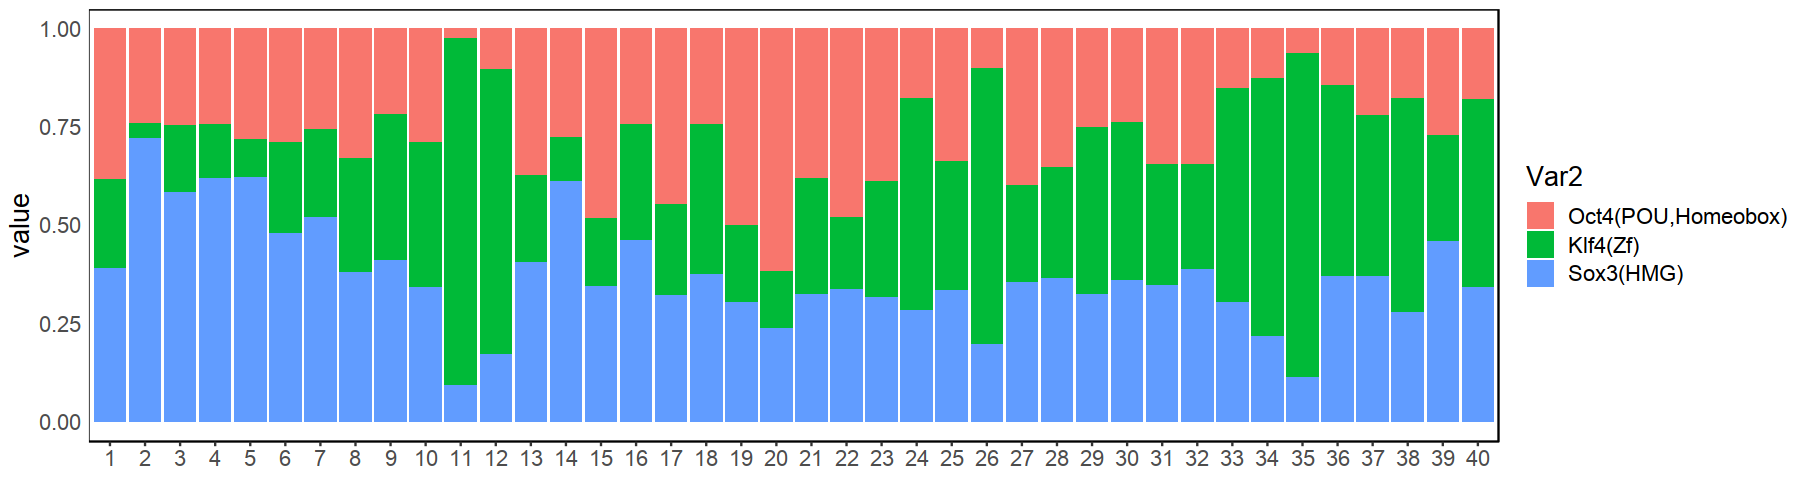

In [1320]:
options(repr.plot.width = 15, repr.plot.height = 4)

ggplot(osk_frac_melted, aes(x=Var1, y=value, fill=Var2)) +
geom_bar(position='fill', stat='identity') +
theme_classic() +
theme(plot.title = element_text(hjust = 0.5),
    text = element_text(size=16),
    axis.line=element_blank(),
    axis.ticks.y=element_blank(),
    axis.title.x = element_blank(),
    panel.border = element_rect(colour = "black", fill=NA, size=0.5))